<a href="https://colab.research.google.com/github/jeonniga/pytorch-dqn/blob/main/2_3_Policygradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구현에 사용할 패키지 임포트하기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

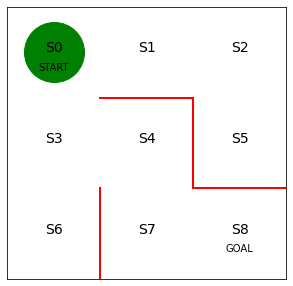

In [ ]:
# 초기 상태의 미로 모습

# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 붉은 벽 그리기
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 상태를 의미하는 문자열(S0~S8) 표시
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

# S0에 녹색 원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [ ]:
# 정책을 결정하는 파라미터의 초깃값 theta_0를 설정

# 줄은 상태 0~7, 열은 행동방향(상,우,하,좌 순)를 나타낸다
theta_0 = np.array([[np.nan, 1, 1, np.nan],       # s0
                    [np.nan, 1, np.nan, 1],       # s1
                    [np.nan, np.nan, 1, 1],       # s2
                    [1, 1, 1, np.nan],            # s3
                    [np.nan, np.nan, 1, 1],       # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],       # s7、※s8은 목표지점이므로 정책이 없다
                    ])

In [ ]:
# 정책 파라미터 theta를 행동정책 pi로 변환(소프트맥스 함수 사용)하는 함수
def softmax_convert_into_pi_from_theta(theta):
    '''비율 계산에 소프트맥스 함수 사용'''

    beta = 1.0
    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # theta를 exp(theta)로 변환

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # 단순 비율을 계산하는 코드

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmax로 계산하는 코드

    pi = np.nan_to_num(pi)  # nan을 0으로 변환

    return pi

In [ ]:
# 초기 정책 pi_0을 계산
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [ ]:
# 행동 a를 취한 후의 상태 s를 구하는 함수

def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]의 확률을 따라, direction값이 선택된다
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 위로 이동하면 상태값이 3 줄어든다
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 오른쪽으로 이동하면 상태값이 1 늘어난다
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 아래로 이동하면 상태값이 3 늘어난다
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 왼쪽으로 이동하면 상태값이 1 줄어든다

    return [action, s_next]

In [ ]:
# 미로를 빠져나오는 함수, 상태와 행동의 히스토리를 출력한다


def goal_maze_ret_s_a(pi):
    s = 0  # 시작 지점
    s_a_history = [[0, np.nan]]  # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트

    while (1):  # 목표 지점에 이를 때까지 반복
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 현재 상태(마지막이므로 인덱스가 -1)를 히스토리에 추가

        s_a_history.append([next_s, np.nan])
        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan으로 둔다.

        if next_s == 8:  # 목표 지점에 이르면 종료
            break
        else:
            s = next_s

    return s_a_history

In [ ]:
# 초기 정책으로 미로를 빠져나오기
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

[[0, 2], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다


In [ ]:
# theta를 수정하는 함수

def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 학습률
    T = len(s_a_history) - 1                # 목표 지점에 이르기까지 걸린 단계 수

    [m, n] = theta.shape                    # theta의 행렬 크기를 구함
    delta_theta = theta.copy()              # Δtheta를 구할 준비, 포인터 참조이므로 delta_theta = theta로는 안됨

    # delta_theta를 요소 단위로 계산
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # theta가 nan이 아닌 경우

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 히스토리에서 상태 i인 것만 모아오는 리스트 컴프리헨션

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 상태 i에서 행동 j를 취한 경우만 모음

                N_i = len(SA_i)             # 상태 i에서 모든 행동을 취한 횟수
                N_ij = len(SA_ij)           # 상태 i에서 행동 j를 취한 횟수 
                
                # 초판에서 부호 오류가 있었음(수정일 : 1807030
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [ ]:
# 정책 수정
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.49583343 0.50416657 0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33147637 0.33704727 0.33147637 0.        ]
 [0.         0.         0.50833256 0.49166744]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [ ]:
# 정책 경사 알고리즘으로 미로 빠져나오기

stop_epsilon = 10**-4                                       # 정책의 변화가 10^-4 보다 작아지면 학습을 종료


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:                                          # is_continue가 False가 될 때까지 반복
    s_a_history = goal_maze_ret_s_a(pi)                     # 정책 π를 따라 미로를 탐색한 히스토리를 구함
    new_theta = update_theta(theta, pi, s_a_history)        # 파라미터 Θ를 수정
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 정책 π를 수정

    print(np.sum(np.abs(new_pi - pi)))                      # 정책의 변화를 출력
    print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0.002736010795933469
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0027822779243609035
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0033075059771292374
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0006915768473098778
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006887440737065875
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006859289833858993
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006831314276616526
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.000680351259419669
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006775883330964669
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006748425046589207
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006721136315859279
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006694015728501458
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006667061888960928
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0033035786373812603
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0006773705622515475
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006746111593964252
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006718689368611017
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.000669143750216903
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0006664354565640816
목표 지점에 이르기까지 걸린 단계 수는 4단계입니

In [ ]:
# 학습이 끝난 정책을 확인
np.set_printoptions(precision=3, suppress=True)  # 有効桁数3、指数表示しないという設定
print(pi)

[[0.    0.01  0.99  0.   ]
 [0.    0.314 0.    0.686]
 [0.    0.    0.42  0.58 ]
 [0.012 0.974 0.014 0.   ]
 [0.    0.    0.985 0.015]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.014 0.986 0.    0.   ]]


In [ ]:
# 에이전트의 이동 과정을 시각화
# 참고 URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 배경 이미지 초기화
    line.set_data([], [])
    return (line,)


def animate(i):
    # 프레임 단위로 이미지 생성
    state = s_a_history[i][0]   # 현재 위치
    x = (state % 3) + 0.5       # 상태의 x좌표 : 3으로 나눈 나머지 + 0.5
    y = 2.5 - int(state / 3)    # y좌표 : 2.5에서 3으로 나눈 몫을 뺌
    line.set_data(x, y)
    return (line,)


#　초기화 함수와 프레임 단위 이미지 생성한수를 사용하여 애니메이션 생성
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())